In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [3]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    logp = logp(x) - np.log(2)
    return np.logaddexp(logp, logp(x))

In [5]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [6]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [9]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0
    
    for t in range(steps): 
        prop = x + step * grad_logp(x) + np.sqrt(2 * step) * rng.normal(0, 1, size=d)

        forward_log_prob = -0.25 / step * np.sum((prop - x - step * grad_logp(x)) ** 2)
        backward_log_prob = -0.25 / step * np.sum((x - prop - step * grad_logp(prop)) ** 2)

        log_alpha = logp(prop) - logp(x) + backward_log_prob - forward_log_prob

        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x
    return chain, accept / steps

In [11]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например



mala_step = 0.5 # тут попробуйте подобрать хороший шаг
mh_scale = 0.7 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

    
mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

mh_esses = []
mala_esses = []

for dim in range(d):
    mh_esses.append(ess(mh_chain[burn:, dim]))
    mala_esses.append(ess(mala_chain[burn:, dim]))

mh_ess = np.median(mh_esses)
mala_ess = np.median(mala_esses)


print(f"acceptance-rate mh: {mh_acc}")
print(f"mh ess: {mh_ess}")
print(f"acceptance-rate mala: {mala_acc}")
print(f"mala ess: {mala_ess}")


acceptance-rate mh: 0.2965333333333333
mh ess: 862.3869291657334
acceptance-rate mala: 0.7012333333333334
mala ess: 6762.91523297542


<function matplotlib.pyplot.show(close=None, block=None)>

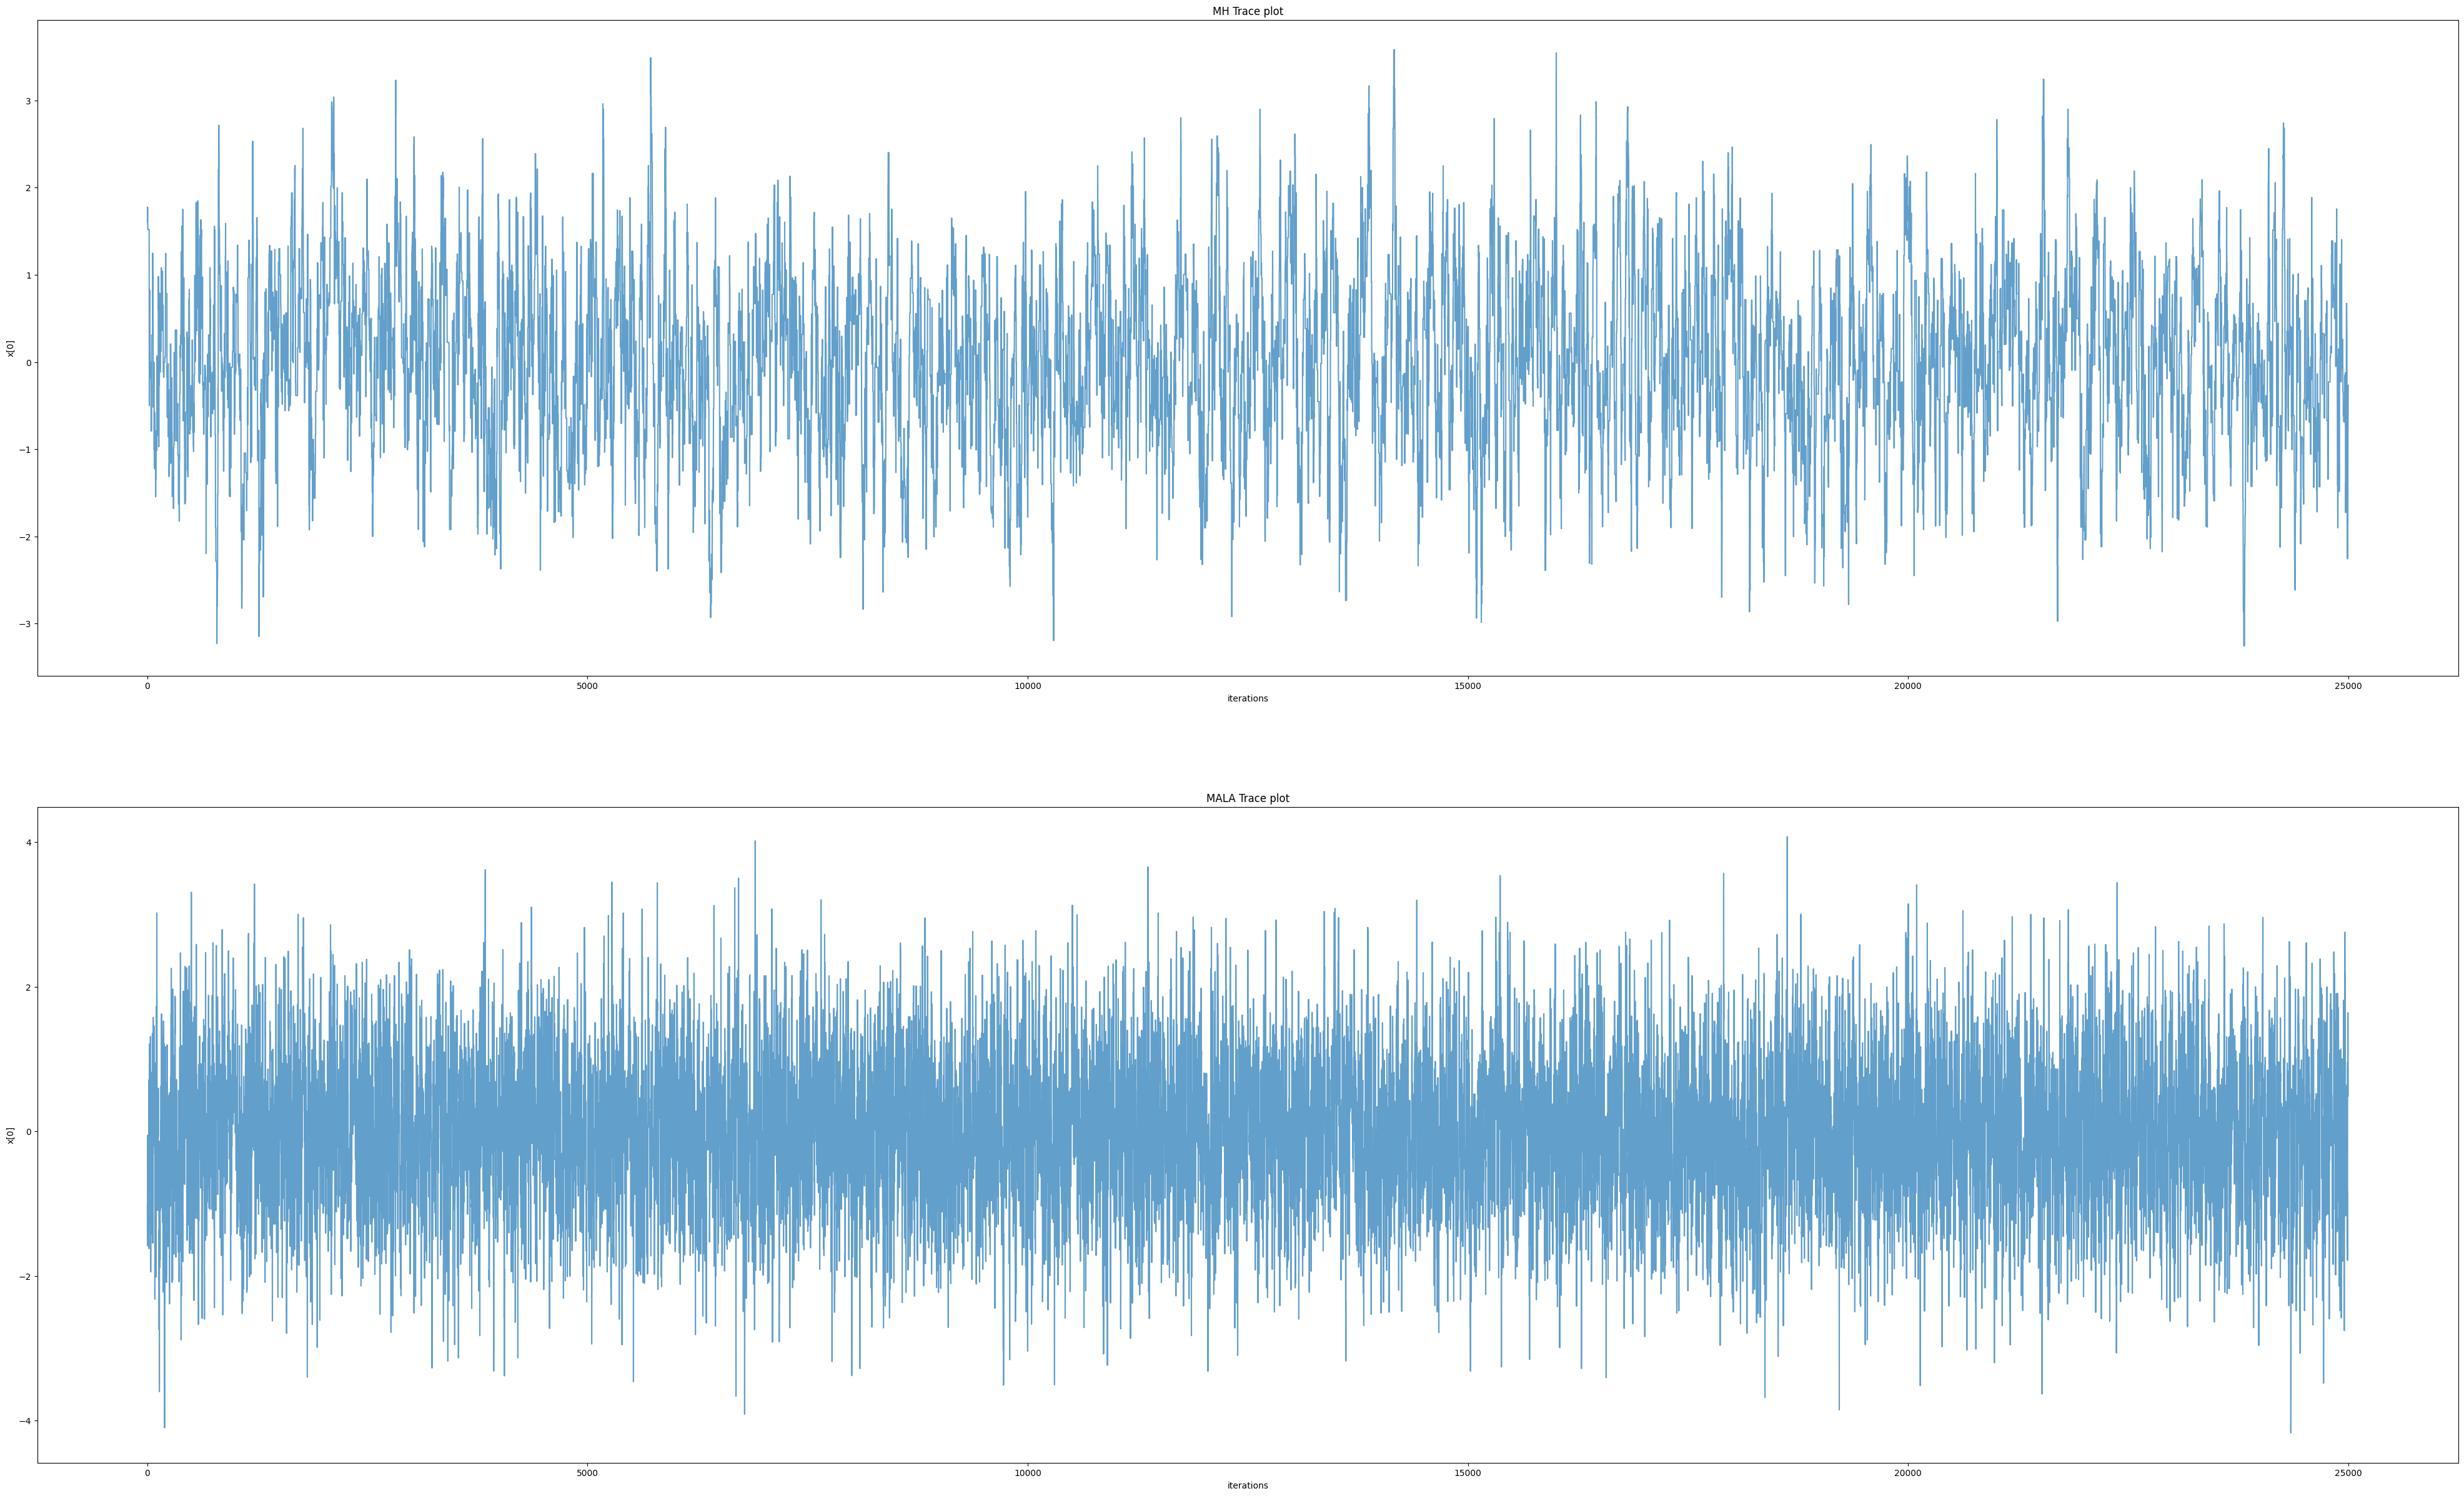

In [13]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

mh_samples = mh_chain[burn:, 0]
mala_samples = mala_chain[burn:, 0]
fig = plt.figure(figsize=(50, 30))
plt.subplot(2, 1, 1)
plt.plot(mh_samples, alpha=0.7)
plt.title('MH Trace plot')
plt.xlabel('iterations')
plt.ylabel('x[0]')


plt.subplot(2, 1, 2)
plt.plot(mala_samples, alpha=0.7)
plt.title('MALA Trace plot')
plt.xlabel('iterations')
plt.ylabel('x[0]')
plt.show

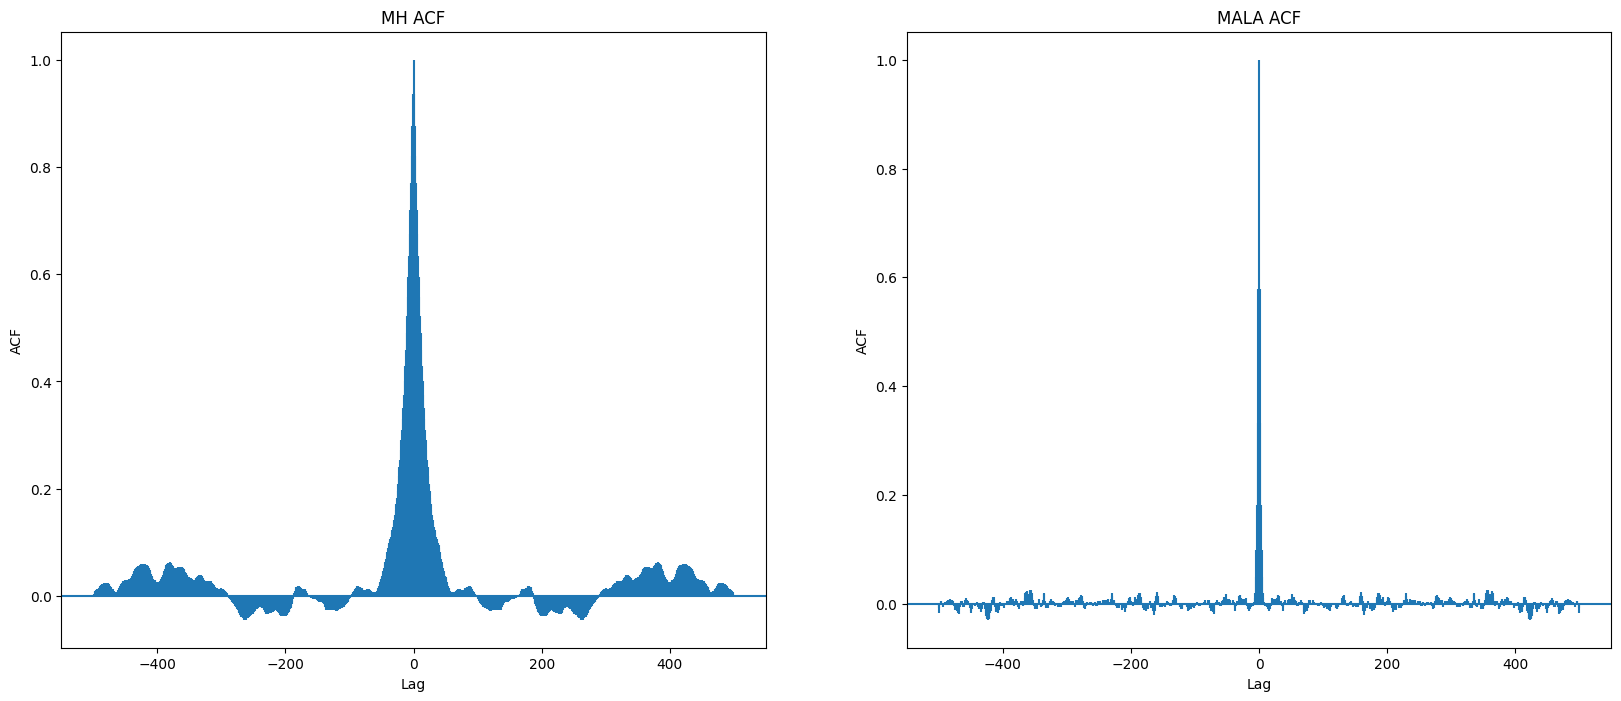

In [14]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.acorr(mh_samples, maxlags=500)
plt.title('MH ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')


plt.subplot(1, 2, 2)
plt.acorr(mala_samples, maxlags=500)
plt.title('MALA ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

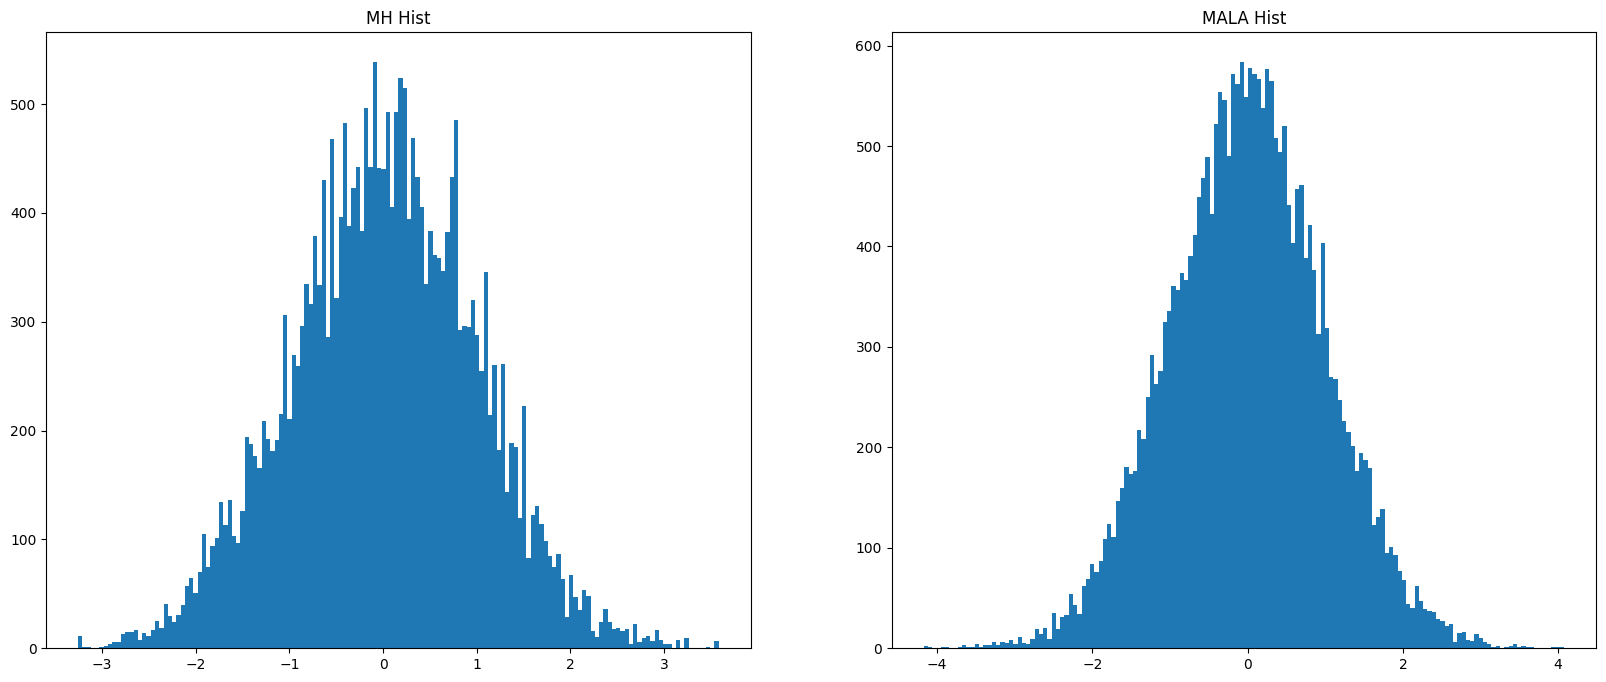

In [16]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(mh_samples,bins=150)
plt.title('MH Hist')


plt.subplot(1, 2, 2)
plt.hist(mala_samples, bins=150)
plt.title('MALA Hist')
plt.show()